In [1]:
from utils.openai_helpers import query_openai_model
from utils.preprocess_functions import convert_to_triplets, top_n_entities, triplets_containing_entity
from utils.preprocess_functions import get_labels_and_descriptions_for_triplets, format_triplets_text
from utils.wiki_helpers import get_label_for_qid, get_triplet_labels
from utils.prompt_functions import get_prompt_v1, get_prompt_v2
from utils.graph_plotting_helpers import plot_triplets_graph, plot_graph
# from utils.plotting_helpers import plot_count_distribution
import json

In [2]:
import cugraph
import cudf

In [3]:
import networkx as nx
# import cugraph as cnx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
with open('inputs/wikidata5m/wikidata5m_transductive_valid.txt', 'r') as file:
    wiki_valid = file.readlines()
with open('inputs/wikidata5m/wikidata5m_transductive_train.txt', 'r') as file:
    wiki_train = file.readlines()

In [5]:
list_of_triplets = convert_to_triplets(wiki_valid)

In [6]:
list_of_triplets[:5]

[('Q3576734', 'P495', 'Q30'),
 ('Q641724', 'P1412', 'Q1860'),
 ('Q959357', 'P39', 'Q49476'),
 ('Q4263990', 'P105', 'Q7432'),
 ('Q4119101', 'P171', 'Q2906912')]

In [7]:
def create_graph_from_triplets(triplets):
    """
    Creates a directed graph using cugraph from a list of triplets.
    Each triplet contains (source, relationship, destination).
    
    :param triplets: List of triplet tuples (source, relationship, destination)
    :return: A cugraph Graph or DiGraph object
    """
    edges = [(src, dst) for src, _, dst in triplets]
    df = cudf.DataFrame(edges, columns=['src', 'dst'])
    G = cugraph.Graph()

    # Add edges to the graph using the DataFrame
    G.from_cudf_edgelist(df, source='src', destination='dst')#, renumber=True)

    return G


In [8]:
len(list_of_triplets)

5163

In [9]:
list_of_triplets[:5]

[('Q3576734', 'P495', 'Q30'),
 ('Q641724', 'P1412', 'Q1860'),
 ('Q959357', 'P39', 'Q49476'),
 ('Q4263990', 'P105', 'Q7432'),
 ('Q4119101', 'P171', 'Q2906912')]

In [10]:
def create_graph_from_triplets_nx(triplets):
    """
    Creates a directed graph using cugraph from a list of triplets.
    Each triplet contains (source, relationship, destination).
    
    :param triplets: List of triplet tuples (source, relationship, destination)
    :return: A cugraph Graph or DiGraph object
    """
    G = nx.DiGraph()
    for src, rel, tgt in triplets:
        G.add_edge(src, tgt, relation=rel)

    return G


In [11]:
Gx = create_graph_from_triplets(list_of_triplets)

/anaconda/envs/kg/lib/python3.9/site-packages/cugraph/structure/symmetrize.py:93: FutureWarning: Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'. Multi edges will be removed upon creation of graph instance.
  warnings.warn(


In [12]:
G = create_graph_from_triplets_nx(list_of_triplets)

In [13]:
Gx.number_of_nodes()

8002

In [14]:
G.number_of_nodes()

8002

In [15]:
louvain_communities = cugraph.louvain(Gx)

In [16]:
louvain_communities[0]['partition'].unique()

0       1860
1        180
2        117
3       1584
4        103
        ... 
2834     384
2835    2740
2836    1894
2837    1895
2838     357
Name: partition, Length: 2839, dtype: int32

In [17]:
df_lc = louvain_communities[0]['partition'].to_frame()

In [18]:
df_lc

,partition
0,1860
1,180
2,117
3,1584
4,103
...,...
7997,2202
7998,2197
7999,6
8000,626


In [19]:
df_lc['qid'] = Gx.nodes()

In [20]:
df_lc

,partition,qid
0,1860,Q340
1,180,Q39614
2,117,Q5616837
3,1584,Q4245563
4,103,Q14834249
...,...,...
7997,2202,Q184163
7998,2197,Q5612796
7999,6,Q8138
8000,626,Q16240996


In [21]:
partitions = df_lc['partition'].to_frame()['partition'].to_numpy()
partitions = list(partitions)

qid = df_lc['qid'].to_frame()['qid'].to_numpy()
qid = list(qid)
#convert to list

In [22]:
nodes_idx = list(range(0, len(partitions)))

In [23]:
data = {
    'partition': partitions,
    'node': nodes_idx,
    'qid': qid
}

df_partitions = pd.DataFrame(data)

In [24]:
df_partitions

,partition,node,qid
0,1860,0,Q340
1,180,1,Q39614
2,117,2,Q5616837
3,1584,3,Q4245563
4,103,4,Q14834249
...,...,...,...
7997,2202,7997,Q184163
7998,2197,7998,Q5612796
7999,6,7999,Q8138
8000,626,8000,Q16240996


In [25]:
grouped = df_partitions.groupby('partition')['qid'].agg(list).reset_index(name='qid_grouped')

In [26]:
grouped

,partition,qid_grouped
0,0,"[Q6608367, Q650137, Q365935, Q16214176, Q949302]"
1,1,"[Q161345, Q588688, Q7618284, Q1899350, Q18702007]"
2,2,"[Q34740, Q369806, Q5257777, Q810807, Q1564528,..."
3,3,"[Q875049, Q401272, Q524490, Q4721995, Q1352136..."
4,4,"[Q777074, Q5930359, Q14350274, Q2820663, Q4074..."
...,...,...
2834,2834,"[Q3446091, Q9798]"
2835,2835,"[Q128290, Q383626]"
2836,2836,"[Q3918, Q5236795]"
2837,2837,"[Q294583, Q93204]"


In [27]:
grouped.iloc[0]['qid_grouped']

['Q6608367', 'Q650137', 'Q365935', 'Q16214176', 'Q949302']

In [28]:
G.number_of_edges()

5163

In [29]:
# Add the 'size' column
grouped['size'] = grouped['qid_grouped'].apply(len)

# # Reorder columns if needed
# grouped = grouped[['partition', 'size', 'nodes']]

In [30]:
grouped[grouped['size'] > 4]

,partition,qid_grouped,size
0,0,"[Q6608367, Q650137, Q365935, Q16214176, Q949302]",5
1,1,"[Q161345, Q588688, Q7618284, Q1899350, Q18702007]",5
2,2,"[Q34740, Q369806, Q5257777, Q810807, Q1564528,...",40
3,3,"[Q875049, Q401272, Q524490, Q4721995, Q1352136...",23
4,4,"[Q777074, Q5930359, Q14350274, Q2820663, Q4074...",12
...,...,...,...
983,983,"[Q7333362, Q6417678, Q20108810, Q117415, Q1653...",5
1139,1139,"[Q7084667, Q15485371, Q17319037, Q55665, Q1637...",5
1198,1198,"[Q1020674, Q6170431, Q316080, Q8000073, Q25485...",6
1493,1493,"[Q215952, Q205587, Q15713163, Q4830453, Q65765...",6


In [44]:
node_ids = list(grouped.loc[0]['qid_grouped'])


In [46]:
node_ids

['Q6608367', 'Q650137', 'Q365935', 'Q16214176', 'Q949302']

In [47]:
# Create subgraph
sg = G.subgraph(node_ids)

# Now, you should have a subgraph 'sg' with all nodes and edges between them from the original graph 'G'
print("Number of nodes:", sg.number_of_nodes())
print("Number of edges:", sg.number_of_edges())

Number of nodes: 5
Number of edges: 0


In [1]:
G.number_of_edges()

NameError: name 'G' is not defined

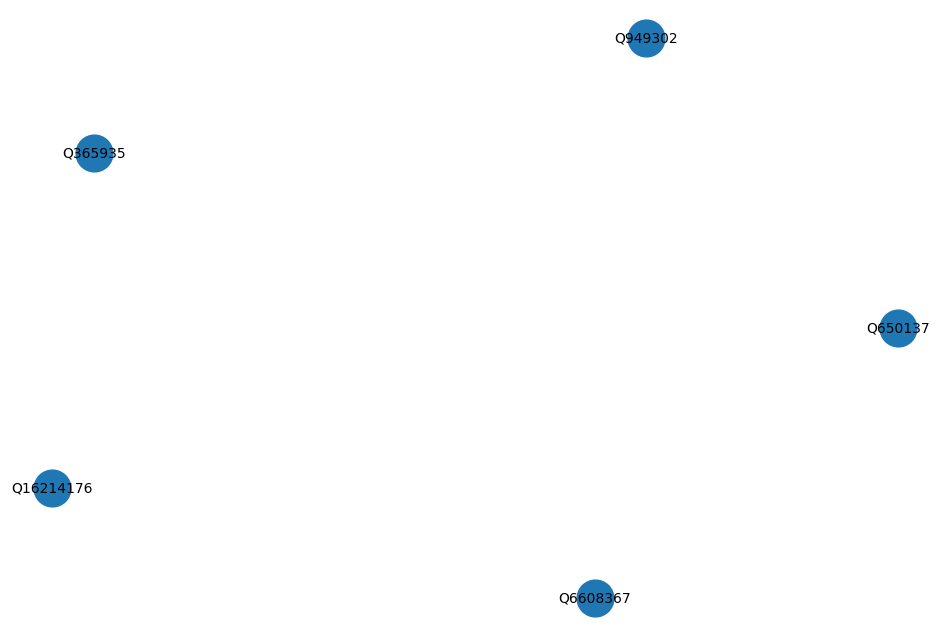

In [48]:
plot_graph(sg)

In [49]:
for i in range(len(node_ids)):
    print(get_label_for_qid(node_ids[i]))

('Indiana University', 'university system, Indiana, United States')
('Oleh Shamshur', 'Ukrainian diplomat')
('Andrew Marvell', 'English poet and politician (1621–1678)')
('Anderson Jorge dos Santos', 'Brazilian sprinter')
('skin disease', 'class of disorder that affects skin, hair or nails')


In [ ]:
Sg = cugraph.subgraph(Gx, req)

In [55]:
Gx.nodes()

0            Q340
1          Q39614
2        Q5616837
3        Q4245563
4       Q14834249
          ...    
7997      Q184163
7998     Q5612796
7999        Q8138
8000    Q16240996
8001        Q1571
Name: 0, Length: 8002, dtype: object

In [51]:
req = grouped[grouped['partition'] == 1599]['qid_grouped'].to_list()[0]

In [53]:
req = np.array(req)
req = cudf.Series(req)

In [54]:
req

0     Q5070027
1    Q28229688
2     Q3176482
3      Q216344
4     Q4753306
5     Q7483901
dtype: object

In [52]:
leiden_communities = cugraph.leiden(Gx)

In [54]:
leiden_communities[0]['partition'].unique()

0          8
1          0
2          4
3          1
4        145
        ... 
1622    1498
1623    1522
1624    1578
1625    1561
1626    1625
Name: partition, Length: 1627, dtype: int32

In [40]:
leiden_communities[0]['partition'].to_frame()#.to_csv('outputs/leiden_communities.csv')

,partition
0,1859
1,176
2,113
3,1583
4,99
...,...
7997,204
7998,205
7999,206
8000,2774


In [41]:
df_comm = leiden_communities[0]['partition'].to_frame()

In [42]:
df_comm.groupby('partition').count()

""
partition
2415
1966
1136
1458
1848
...
2498
2510
348


In [12]:
communities_generator_leiden = cnx.community.leiden(Gx)

In [13]:
communities_generator_leiden[0]['partition'].unique()

0       1859
1        176
2        113
3       1583
4         99
        ... 
2834    1867
2835    2694
2836    1801
2837    1465
2838    1255
Name: partition, Length: 2839, dtype: int32

In [28]:
ktruss_comm = cugraph.k_truss(Gx, 3)

/anaconda/envs/kg/lib/python3.9/site-packages/cugraph/community/ktruss_subgraph.py:193: FutureWarning: The use_weights flag is deprecated and will be removed in the next release. if weights were passed at the graph creation, they will be used.
  warnings.warn(warning_msg, FutureWarning)
/anaconda/envs/kg/lib/python3.9/site-packages/cudf/core/index.py:1116: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  warnings.warn(
/anaconda/envs/kg/lib/python3.9/site-packages/cugraph/structure/symmetrize.py:93: FutureWarning: Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'. Multi edges will be removed upon creation of graph instance.
  warnings.warn(


In [32]:
ktruss_comm = cugraph.ktruss_subgraph(Gx, 3)

/anaconda/envs/kg/lib/python3.9/site-packages/cugraph/community/ktruss_subgraph.py:193: FutureWarning: The use_weights flag is deprecated and will be removed in the next release. if weights were passed at the graph creation, they will be used.
  warnings.warn(warning_msg, FutureWarning)
/anaconda/envs/kg/lib/python3.9/site-packages/cudf/core/index.py:1116: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  warnings.warn(
/anaconda/envs/kg/lib/python3.9/site-packages/cugraph/structure/symmetrize.py:93: FutureWarning: Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'. Multi edges will be removed upon creation of graph instance.
  warnings.warn(


In [33]:
ktruss_comm.number_of_nodes()

0

In [35]:
ktruss_subgraphs = cnx.k_truss_subgraph(Gx, 2)

AttributeError: module 'cugraph' has no attribute 'k_truss_subgraph'

In [26]:
communities_generator_ktruss.number_of_edges()

5163

In [27]:
communities_generator_ego = cnx.ego_graph(Gx, 1)

ValueError: Could not convert strings to float type due to presence of non-floating values.

In [33]:
import cugraph.datasets.karate as karate
G = karate.get_graph(download=True)
k_subgraph = cugraph.k_truss(G, 3)

ModuleNotFoundError: No module named 'cugraph.datasets.karate'

In [19]:
cnx.betweenness_centrality(G)

/anaconda/envs/kg/lib/python3.9/site-packages/cugraph/structure/symmetrize.py:93: FutureWarning: Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'. Multi edges will be removed upon creation of graph instance.
  warnings.warn(


{'Q100': 0.0,
 'Q1000073': 0.0,
 'Q100011': 0.0,
 'Q100066': 0.0,
 'Q1002499': 0.0,
 'Q1003921': 0.0,
 'Q1003966': 0.0,
 'Q100406': 0.0,
 'Q1004462': 0.0,
 'Q1004666': 0.0,
 'Q1004748': 0.0,
 'Q1004857': 0.0,
 'Q1004908': 0.0,
 'Q1004909': 0.0,
 'Q1005719': 0.0,
 'Q1005746': 0.0,
 'Q1008412': 0.0,
 'Q1009': 0.0,
 'Q1009348': 0.0,
 'Q1012264': 0.0,
 'Q1013': 0.0,
 'Q1013176': 0.0,
 'Q101352': 0.0,
 'Q1013843': 0.0,
 'Q1014': 0.0,
 'Q1016': 0.0,
 'Q1017': 0.0,
 'Q101751': 0.0,
 'Q1017583': 0.0,
 'Q1017938': 0.0,
 'Q1017947': 0.0,
 'Q1018174': 0.0,
 'Q1020488': 0.0,
 'Q1020674': 0.0,
 'Q1020762': 0.0,
 'Q10225': 0.0,
 'Q1022904': 0.0,
 'Q1023222': 0.0,
 'Q1023330': 0.0,
 'Q102364': 0.0,
 'Q1024183': 0.0,
 'Q1024264': 0.0,
 'Q102438': 0.0,
 'Q1024468': 0.0,
 'Q1024897': 0.0,
 'Q1025': 0.0,
 'Q1025333': 0.0,
 'Q1026120': 0.0,
 'Q1026207': 0.0,
 'Q1026685': 0.0,
 'Q1026810': 0.0,
 'Q1026868': 0.0,
 'Q1026892': 0.0,
 'Q1027030': 0.0,
 'Q1027413': 0.0,
 'Q1027689': 0.0,
 'Q10278007': 0.0,
 'Q1

In [18]:
nx.betweenness_centrality(G)

{'Q3576734': 0.0,
 'Q30': 0.0,
 'Q641724': 0.0,
 'Q1860': 0.0,
 'Q959357': 0.0,
 'Q49476': 0.0,
 'Q4263990': 0.0,
 'Q7432': 0.0,
 'Q4119101': 0.0,
 'Q2906912': 0.0,
 'Q28059918': 0.0,
 'Q23792': 0.0,
 'Q6544227': 0.0,
 'Q5': 0.0,
 'Q7146631': 0.0,
 'Q13628140': 0.0,
 'Q1524': 0.0,
 'Q6782577': 0.0,
 'Q2392096': 0.0,
 'Q14236316': 0.0,
 'Q1302291': 0.0,
 'Q1702691': 0.0,
 'Q4677161': 0.0,
 'Q2259133': 0.0,
 'Q2743': 0.0,
 'Q7051497': 0.0,
 'Q4921928': 0.0,
 'Q1904': 0.0,
 'Q4037104': 0.0,
 'Q208850': 0.0,
 'Q3586535': 0.0,
 'Q858439': 0.0,
 'Q18205522': 0.0,
 'Q145': 1.0311211098612675e-06,
 'Q4164280': 0.0,
 'Q15180': 0.0,
 'Q6373910': 0.0,
 'Q486972': 0.0,
 'Q17109993': 0.0,
 'Q6752337': 0.0,
 'Q189004': 0.0,
 'Q4613378': 0.0,
 'Q1634225': 0.0,
 'Q5592199': 0.0,
 'Q784781': 0.0,
 'Q336286': 0.0,
 'Q3054694': 0.0,
 'Q7968222': 0.0,
 'Q7853876': 0.0,
 'Q7914238': 0.0,
 'Q51404': 0.0,
 'Q5423681': 0.0,
 'Q1981593': 0.0,
 'Q7137789': 0.0,
 'Q50258': 0.0,
 'Q4724940': 0.0,
 'Q3616': 0.0,
 

In [26]:
G = cnx.Graph(directed=True)

In [16]:
len(next_level_communities[0])

203

In [17]:
next_level_communities[0]

{'Q1039003',
 'Q10820793',
 'Q1094440',
 'Q11351555',
 'Q1135856',
 'Q11727910',
 'Q1239913',
 'Q1347036',
 'Q13560374',
 'Q1436820',
 'Q14598713',
 'Q14681975',
 'Q14686005',
 'Q14688005',
 'Q14705116',
 'Q14705278',
 'Q14706273',
 'Q1553015',
 'Q16017427',
 'Q16018413',
 'Q16019667',
 'Q16078885',
 'Q16093599',
 'Q16186707',
 'Q16193137',
 'Q16210893',
 'Q16236690',
 'Q16499870',
 'Q168274',
 'Q16835661',
 'Q16893536',
 'Q17092236',
 'Q17109993',
 'Q17510758',
 'Q1766934',
 'Q178115',
 'Q18601255',
 'Q186192',
 'Q1910549',
 'Q1911285',
 'Q1941611',
 'Q19460422',
 'Q19574749',
 'Q19627358',
 'Q19819883',
 'Q19864164',
 'Q2005382',
 'Q20063702',
 'Q2023618',
 'Q2073821',
 'Q20950026',
 'Q215026',
 'Q2230146',
 'Q22350799',
 'Q2241355',
 'Q232547',
 'Q2371779',
 'Q2392096',
 'Q24034636',
 'Q24041373',
 'Q2412852',
 'Q245354',
 'Q2507854',
 'Q258705',
 'Q26251812',
 'Q2732407',
 'Q2820663',
 'Q28229688',
 'Q2902398',
 'Q30',
 'Q3047214',
 'Q3054694',
 'Q31292',
 'Q314269',
 'Q3204109',
 

In [11]:
def plot_girvan_newman_subgraphs(communities_generator, graph):
    # # Apply the Girvan-Newman algorithm to identify subgraphs (communities)
    # communities_generator = nx.algorithms.community.girvan_newman(graph)
    
    # Extract the first division of the network into subgraphs
    top_level_communities = next(communities_generator)
    
    # Generate a mapping of node to community index for visualization
    community_map = {}
    for community_index, community in enumerate(top_level_communities):
        for node in community:
            community_map[node] = community_index
    
    # Assign colors to nodes based on their community
    node_colors = [community_map[node] for node in graph.nodes()]
    
    # Plot the graph
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.tab10)
    plt.title("Subgraphs Detected by the Girvan-Newman Method")
    plt.show()



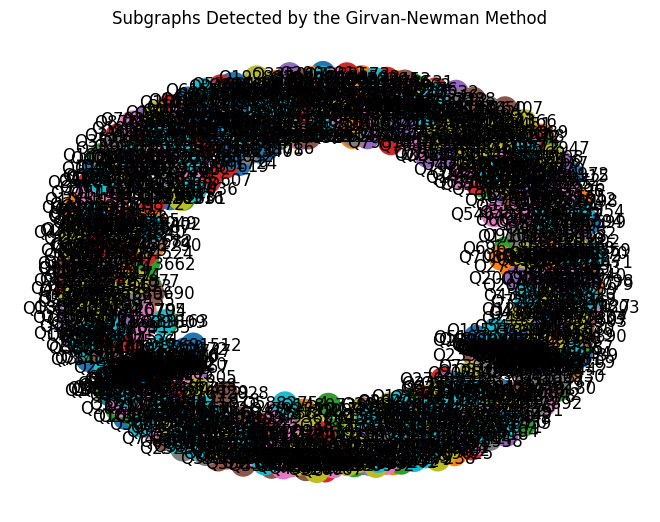

In [12]:
# # Create a simple graph to test the function
# G = nx.karate_club_graph()
plot_girvan_newman_subgraphs(communities_generator, G)

In [20]:
next_level_communities

({'Q1039003',
  'Q10820793',
  'Q1094440',
  'Q11351555',
  'Q1135856',
  'Q11727910',
  'Q1239913',
  'Q1347036',
  'Q13560374',
  'Q1436820',
  'Q14598713',
  'Q14681975',
  'Q14686005',
  'Q14688005',
  'Q14705116',
  'Q14705278',
  'Q14706273',
  'Q1553015',
  'Q16017427',
  'Q16018413',
  'Q16019667',
  'Q16078885',
  'Q16093599',
  'Q16186707',
  'Q16193137',
  'Q16210893',
  'Q16236690',
  'Q16499870',
  'Q168274',
  'Q16835661',
  'Q16893536',
  'Q17092236',
  'Q17109993',
  'Q17510758',
  'Q1766934',
  'Q178115',
  'Q18601255',
  'Q186192',
  'Q1910549',
  'Q1911285',
  'Q1941611',
  'Q19460422',
  'Q19574749',
  'Q19627358',
  'Q19819883',
  'Q19864164',
  'Q2005382',
  'Q20063702',
  'Q2023618',
  'Q2073821',
  'Q20950026',
  'Q215026',
  'Q2230146',
  'Q22350799',
  'Q2241355',
  'Q232547',
  'Q2371779',
  'Q2392096',
  'Q24034636',
  'Q24041373',
  'Q2412852',
  'Q245354',
  'Q2507854',
  'Q258705',
  'Q26251812',
  'Q2732407',
  'Q2820663',
  'Q28229688',
  'Q2902398',
  

In [7]:
def detect_communities(G):
    G_undirected = G.to_undirected()
    
    # Compute the best partition (community detection) 
    partition = community_louvain.best_partition(G_undirected)
    
    # Print the number of communities detected
    num_communities = len(set(partition.values()))
    print(f"Number of detected communities: {num_communities}")
    
    # Create a dictionary of subgraphs for each community
    community_subgraphs = {}
    for node, community_id in partition.items():
        if community_id not in community_subgraphs:
            community_subgraphs[community_id] = nx.DiGraph()
        community_subgraphs[community_id].add_node(node, **G.nodes[node])
        for neighbor in G.neighbors(node):
            if partition[neighbor] == community_id:
                community_subgraphs[community_id].add_edge(node, neighbor, **G.edges[node, neighbor])
    
    return community_subgraphs

In [8]:
def graph_properties(G):
    properties = {}
    
    degrees = [G.degree(n) for n in G.nodes()]
    properties['Degree Distribution'] = degrees


    properties['Clustering Coefficient'] = nx.average_clustering(G.to_undirected())

    if nx.is_strongly_connected(G):
        properties['Average Path Length'] = nx.average_shortest_path_length(G)
        properties['Diameter'] = nx.diameter(G)
    else:
        properties['Average Path Length'] = "Graph is not strongly connected."
        properties['Diameter'] = "Graph is not strongly connected."
    
    # Centrality Measures
    properties['Degree Centrality'] = nx.degree_centrality(G)
    properties['Closeness Centrality'] = nx.closeness_centrality(G)
    properties['Betweenness Centrality'] = nx.betweenness_centrality(G)
    
    # Connectivity
    properties['Node Connectivity'] = nx.node_connectivity(G)
    properties['Edge Connectivity'] = nx.edge_connectivity(G)
    
    # Assortativity
    properties['Assortativity Coefficient'] = nx.degree_assortativity_coefficient(G)
    
    return properties

In [9]:
# req_list = triplets_containing_entity(list_of_triplets, 'Q76')
# req_list_small = req_list[:1000]
# # plot_triplets_graph(req_list)

In [9]:
G = nx.DiGraph()
for src, rel, tgt in list_of_triplets:
        G.add_edge(src, tgt, relation=rel)
print(G.number_of_nodes())


8002


In [10]:
community_subgraphs = detect_communities(G)

Number of detected communities: 2839


In [11]:
len(community_subgraphs)

2839

In [12]:
filtered_communities = []
for i in range(len(community_subgraphs)):
    if community_subgraphs[i].number_of_nodes() > 5:
        g_properties = graph_properties(community_subgraphs[i])
        if g_properties['Average Path Length'] == "Graph is not strongly connected.":
            # print(g_properties['Average Path Length'])
            continue
        else:
            filtered_communities.append(community_subgraphs[i])
print(len(filtered_communities))

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


0


In [ ]:
np.save('filtered_communities.npy', filtered_communities)
json.dump(filtered_communities, open('filtered_communities.json', 'w'))

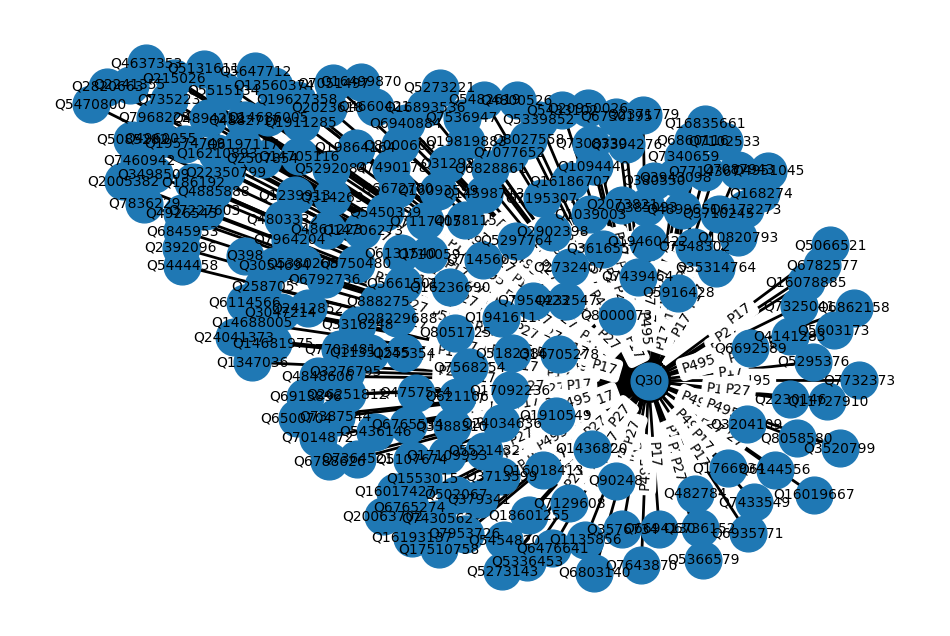

In [ ]:
plot_graph(filtered_communities[0])

In [15]:
community_subgraphs[0].number_of_nodes()

203

In [16]:
g_properties = graph_properties(community_subgraphs[0])
if g_properties['Average Path Length'] == "Graph is not strongly connected.":
    print(g_properties['Average Path Length'])
else:
    print("nnn")

Graph is not strongly connected.


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [24]:
g_properties['Betweenness Centrality'] = 0

In [25]:
g_properties

{'Degree Distribution': 0,
 'Clustering Coefficient': 0.0,
 'Average Path Length': 'Graph is not strongly connected.',
 'Diameter': 'Graph is not strongly connected.',
 'Degree Centrality': 0,
 'Closeness Centrality': 0,
 'Betweenness Centrality': 0,
 'Node Connectivity': 0,
 'Edge Connectivity': 0,
 'Assortativity Coefficient': nan}

In [42]:

# Example Usage
# triples = [('Q299772', 'P27', 'Q38'), ('Q1237249', 'P27', 'Q38'), ('Q59503', 'P495', 'Q38'), ..]
subgraphs = extract_interesting_subgraphs(req_list)
for i, sg in enumerate(subgraphs):
    print(f"Subgraph {i+1}: Nodes = {sg.number_of_nodes()}, Edges = {sg.number_of_edges()}")
    print("Nodes:", sg.nodes())
    print("Edges:", sg.edges(data=True))


Subgraph 1: Nodes = 15, Edges = 0
Nodes: ['Q907056', 'Q21559238', 'Q4002472', 'Q3705548', 'Q52149', 'Q16572571', 'Q3350607', 'Q6757559', 'Q25112864', 'Q3791291', 'Q1282278', 'Q3828595', 'Q1232473', 'Q3637239', 'Q3843927']
Edges: []


In [38]:
G = nx.DiGraph()
for src, rel, tgt in req_list:
        G.add_edge(src, tgt, relation=rel)

In [39]:
G.number_of_edges()

1000

In [50]:
!pip install python-louvain

/bin/bash: /anaconda/envs/azureml_py38_PT_TF/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     |████████████████████████████████| 204 kB 5.8 MB/s eta 0:00:01
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9388 sha256=ba926ef8b7965654ceadc3b16be0f378671251721e32e59c0d6cc441457b2742
  Stored in directory: /home/azureuser/.cache/pip/wheels/af/40/91/ef3635f7d3ddbd889b5af9f1ac22b8d30c48d6f744cd74a6d1
Successfully built python-louvain


In [43]:
communities = community.greedy_modularity_communities(G.to_undirected())

In [12]:
# infomap (https://pypi.org/project/infomap/)
# walktrap (https://www.rdocumentation.org/packages/igraph/versions/0.5.1/topics/walktrap.community)
# leading Eigenvector (https://igraph.org/c/doc/igraph-Community.html#:~:text=The%20leading%20eigenvector%20method%20works,corresponding%20element%20in%20the%20eigenvector.)
# Girvan-Newman (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html)
# Leiden Algorithm (https://leidenalg.readthedocs.io/en/stable/intro.html)

Bad pipe message: %s [b'\xae=\xb2\xd8yZ\xfa\xb9\\\x0b\x1c\xcb\x83\x7f\r\x17\x9f) \xc1\xc7\xc2\xd3aZ\xb1b\xecl\x1cZ\x86\xadV\xc1\xdf\xd1\x1d\xffc\xc0\xbb\xe3?\x07jI\x1c\x81\xf3\xc4\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xd2\x0c\n\xb34\xfc\xeb%\x8f<.\xce\x88v\xaa\xddT?v\xa3^\x06Y}o\x15\xf5)\xf1\xe9\xc4{']
Bad pipe message: %s [b'\x91\xf7M\xec\xf9(\x9ch\x1ej\x9e`\xbb\xb1\xc93\x1a\x9d \xd0\x9dF\xe1\xbb\xd4\xb1V\xfc\x08\x10\xcaO!\x89\x13\xd2\x9d\xdf\xfd*\xc1\x06\xb8\x10\xde\xcd\xcd.\xbf\xda2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\

In [6]:
top_entities = top_n_entities(list_of_triplets)

In [7]:
top_entities

[('Q5', 1519673),
 ('Q30', 810394),
 ('Q16521', 361060),
 ('Q7432', 284558),
 ('Q145', 262873),
 ('Q1860', 228789),
 ('Q2736', 220949),
 ('Q82955', 164131),
 ('Q937857', 149845),
 ('Q6655', 144229),
 ('Q6723', 130997),
 ('Q142', 123849),
 ('Q11424', 117732),
 ('Q486972', 111790),
 ('Q668', 105594),
 ('Q482994', 104547),
 ('Q16', 103411),
 ('Q183', 99210),
 ('Q532', 98303),
 ('Q408', 86565),
 ('Q33999', 79736),
 ('Q34740', 76038),
 ('Q36', 75487),
 ('Q794', 71077),
 ('Q17', 60303),
 ('Q38', 57871),
 ('Q36180', 54486),
 ('Q4830453', 54460),
 ('Q571', 47596),
 ('Q134556', 46263),
 ('Q193592', 44518),
 ('Q29', 42770),
 ('Q1321', 41908),
 ('Q1930187', 40348),
 ('Q150', 39551),
 ('Q159', 39537),
 ('Q4925477', 38843),
 ('Q188', 38554),
 ('Q336286', 37140),
 ('Q55488', 36908),
 ('Q484170', 36793),
 ('Q215380', 35249),
 ('Q84', 34832),
 ('Q40348', 34717),
 ('Q280658', 34293),
 ('Q36834', 34201),
 ('Q148', 33715),
 ('Q5372', 32211),
 ('Q27020041', 31833),
 ('Q20', 31087),
 ('Q4022', 30771),
 ('Q

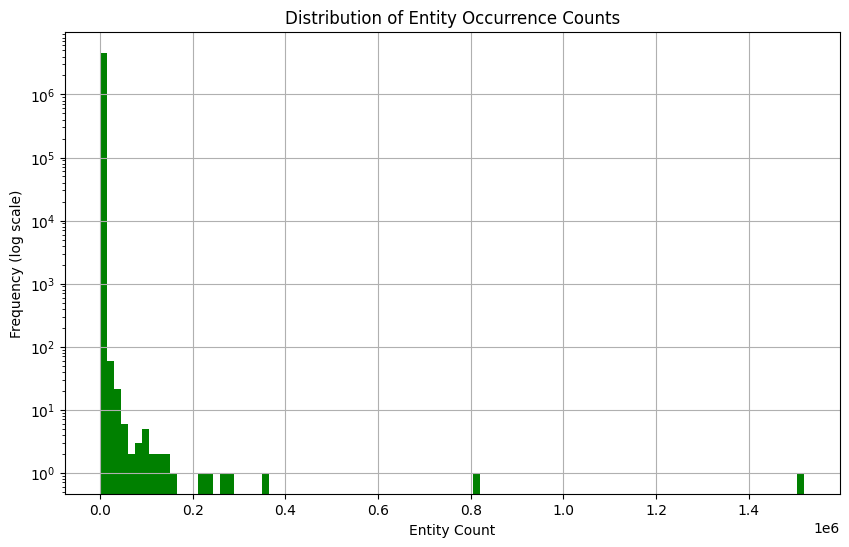

In [8]:
plot_count_distribution(top_entities, bins=100)

In [9]:
req_list = triplets_containing_entity(list_of_triplets, 'Q38')

In [10]:
req_list

[('Q299772', 'P27', 'Q38'),
 ('Q1237249', 'P27', 'Q38'),
 ('Q59503', 'P495', 'Q38'),
 ('Q2936523', 'P17', 'Q38'),
 ('Q1537757', 'P17', 'Q38'),
 ('Q3674395', 'P17', 'Q38'),
 ('Q7810535', 'P27', 'Q38'),
 ('Q3148543', 'P495', 'Q38'),
 ('Q3933080', 'P27', 'Q38'),
 ('Q5394153', 'P27', 'Q38'),
 ('Q25049102', 'P17', 'Q38'),
 ('Q1167835', 'P495', 'Q38'),
 ('Q1281559', 'P17', 'Q38'),
 ('Q4979354', 'P27', 'Q38'),
 ('Q1580885', 'P17', 'Q38'),
 ('Q1873025', 'P495', 'Q38'),
 ('Q4004023', 'P495', 'Q38'),
 ('Q338478', 'P17', 'Q38'),
 ('Q1368481', 'P17', 'Q38'),
 ('Q3772430', 'P27', 'Q38'),
 ('Q3835611', 'P27', 'Q38'),
 ('Q1526115', 'P495', 'Q38'),
 ('Q1878531', 'P17', 'Q38'),
 ('Q51309', 'P17', 'Q38'),
 ('Q3639720', 'P27', 'Q38'),
 ('Q53723', 'P17', 'Q38'),
 ('Q649926', 'P495', 'Q38'),
 ('Q3878322', 'P27', 'Q38'),
 ('Q2791497', 'P27', 'Q38'),
 ('Q2551285', 'P17', 'Q38'),
 ('Q2669614', 'P551', 'Q38'),
 ('Q17380', 'P17', 'Q38'),
 ('Q25112864', 'P17', 'Q38'),
 ('Q672586', 'P27', 'Q38'),
 ('Q40928', 'P17

In [11]:
# generated_text, usage = query_openai_model("What is the capital of France?")

In [12]:
get_label_for_qid('Q3835811')

('Catch as Catch Can', '1967 film by Franco Indovina')

In [13]:
get_triplet_labels(('Q3835811', 'P495', 'Q38'))

(('Catch as Catch Can', 'country of origin', 'Italy'),
 ('1967 film by Franco Indovina',
  'country of origin of this item (creative work, food, phrase, product, etc.)',
  'country in Southern Europe'))

In [11]:
triplet_list, desc_list = get_labels_and_descriptions_for_triplets(req_list)

  0%|          | 10/57870 [00:12<20:47:38,  1.29s/it]


KeyboardInterrupt: 

In [15]:
triplet_list

[('Catch as Catch Can', 'country of origin', 'Italy'),
 ('Lodovico Nulli', 'country of citizenship', 'Italy'),
 ('Giuseppe Danise', 'country of citizenship', 'Italy'),
 ('Gulf of La Spezia', 'country', 'Italy'),
 ('Luigi Ferdinando Tagliavini', 'country of citizenship', 'Italy'),
 ('Ripabianca', 'country', 'Italy'),
 ('Arzani-Volpini', 'country', 'Italy'),
 ('Franco Brusati', 'country of citizenship', 'Italy'),
 ('Anna Palm de Rosa', 'place of death', 'Italy'),
 ('San Zenone degli Ezzelini', 'country', 'Italy'),
 ('Messner Mountain Museum', 'country', 'Italy'),
 ('Sequals', 'country', 'Italy'),
 ('Ho!', 'country of origin', 'Italy'),
 ('Montefioralle', 'country', 'Italy')]

In [12]:
plot_triplets_graph(req_list)

In [16]:
triplet_text = format_triplets_text(triplet_list, desc_list)
print(triplet_text)

(Catch as Catch Can (1967 film by Franco Indovina), country of origin, Italy (country in Southern Europe))
(Lodovico Nulli (sport shooter), country of citizenship, Italy (country in Southern Europe))
(Giuseppe Danise (Italian opera singer (1882-1963)), country of citizenship, Italy (country in Southern Europe))
(Gulf of La Spezia (body of water on the north-western coast of Italy), country, Italy (country in Southern Europe))
(Luigi Ferdinando Tagliavini (Italian musician), country of citizenship, Italy (country in Southern Europe))
(Ripabianca (human settlement in Deruta, Italy), country, Italy (country in Southern Europe))
(Arzani-Volpini (also known as Scuderia Volpini, Italian Formula One constructor), country, Italy (country in Southern Europe))
(Franco Brusati (Italian film director and screenwriter), country of citizenship, Italy (country in Southern Europe))
(Anna Palm de Rosa (Swedish artist (1859-1924)), place of death, Italy (country in Southern Europe))
(San Zenone degli Ez

In [17]:
prompt = get_prompt_v1(triplet_text)
print(prompt)


Use the triplets and their descriptions provided below to generate a coherent paragraph.
You may use only a subset of the triplets if you wish. The focus is to generate a paragraph that is natural, coherent and informative.

Return the paragraph generated, and a mapping for each triplet to the claim in the paragraph that it was used to generate.

Structure your response as a JSON object with the following keys:
- "mapping": A dictionary mapping each claim in the paragraph to the triplet or set of triplets that were used to generate it.
- "paragraph": The paragraph generated

The triplets and their descriptions provided in brackets are as follows:
(Catch as Catch Can (1967 film by Franco Indovina), country of origin, Italy (country in Southern Europe))
(Lodovico Nulli (sport shooter), country of citizenship, Italy (country in Southern Europe))
(Giuseppe Danise (Italian opera singer (1882-1963)), country of citizenship, Italy (country in Southern Europe))
(Gulf of La Spezia (body of wat

In [22]:
generated_text, usage = query_openai_model(prompt)

In [18]:
print(generated_text)

{
  "mapping": {
    "Italy has been the birthplace and home to numerous influential individuals across various fields, including the arts, sports, and cinema.": ["Lodovico Nulli (sport shooter), country of citizenship, Italy (country in Southern Europe)", "Giuseppe Danise (Italian opera singer (1882-1963)), country of citizenship, Italy (country in Southern Europe)", "Luigi Ferdinando Tagliavini (Italian musician), country of citizenship, Italy (country in Southern Europe)", "Franco Brusati (Italian film director and screenwriter), country of citizenship, Italy (country in Southern Europe)"],
    "It also serves as the setting for significant human settlements and natural wonders, contributing to its cultural and geographical diversity.": ["Gulf of La Spezia (body of water on the north-western coast of Italy), country, Italy (country in Southern Europe)", "Ripabianca (human settlement in Deruta, Italy), country, Italy (country in Southern Europe)", "San Zenone degli Ezzelini (Italian 

In [19]:
gen = json.loads(generated_text)

In [20]:
print(gen['paragraph'])

Italy has been the birthplace and home to numerous influential individuals across various fields, including the arts, sports, and cinema. It also serves as the setting for significant human settlements and natural wonders, contributing to its cultural and geographical diversity. Furthermore, Italy's contribution to the automotive and entertainment industries is highlighted through the presence of entities like Arzani-Volpini and the production of films such as 'Catch as Catch Can' and 'Ho!'. The country also attracts international talents and has been the final resting place for notable figures like Anna Palm de Rosa, further enriching its cultural tapestry.


In [21]:
print(gen['mapping'])

{'Italy has been the birthplace and home to numerous influential individuals across various fields, including the arts, sports, and cinema.': ['Lodovico Nulli (sport shooter), country of citizenship, Italy (country in Southern Europe)', 'Giuseppe Danise (Italian opera singer (1882-1963)), country of citizenship, Italy (country in Southern Europe)', 'Luigi Ferdinando Tagliavini (Italian musician), country of citizenship, Italy (country in Southern Europe)', 'Franco Brusati (Italian film director and screenwriter), country of citizenship, Italy (country in Southern Europe)'], 'It also serves as the setting for significant human settlements and natural wonders, contributing to its cultural and geographical diversity.': ['Gulf of La Spezia (body of water on the north-western coast of Italy), country, Italy (country in Southern Europe)', 'Ripabianca (human settlement in Deruta, Italy), country, Italy (country in Southern Europe)', 'San Zenone degli Ezzelini (Italian comune), country, Italy 

In [23]:
print(generated_text)

{
  "mapping": {
    "Italy is renowned for its diverse contributions to culture, sports, and the arts, a tradition that spans from historical towns to the cinematic and operatic stages.": ["Catch as Catch Can (1967 film by Franco Indovina), country of origin, Italy (country in Southern Europe)", "Lodovico Nulli (sport shooter), country of citizenship, Italy (country in Southern Europe)", "Giuseppe Danise (Italian opera singer (1882-1963)), country of citizenship, Italy (country in Southern Europe)", "Luigi Ferdinando Tagliavini (Italian musician), country of citizenship, Italy (country in Southern Europe)", "Franco Brusati (Italian film director and screenwriter), country of citizenship, Italy (country in Southern Europe)"],
    "From the serene Gulf of La Spezia to the charming streets of Ripabianca and Montefioralle, Italy's geography is as rich and varied as its cultural output.": ["Gulf of La Spezia (body of water on the north-western coast of Italy), country, Italy (country in So

In [18]:
prompt = get_prompt_v2(triplet_text)
print(prompt)
generated_text, usage = query_openai_model(prompt)
print(generated_text)


Use the triplets and their descriptions provided below to generate a coherent paragraph.
You may use only a subset of the triplets if you wish. The focus is to generate a paragraph that is natural, coherent and informative.


Return the paragraph generated, and a mapping for each triplet to the claim in the paragraph that it was used to generate.

Structure your response as a JSON object with the following keys:
- "mapping": A dictionary mapping each claim in the paragraph to the triplet or set of triplets that were used to generate it.
- "paragraph": The paragraph generated

NOTE: The mapping only needs to be at the level of the triplet, not the individual entities within the triplet. 
For example, if the paragraph contains the claim "The capital of France is Paris", the mapping should indicate that this claim was generated using the triplet ("France", "capital", "Paris").
Both the subject and object entities should be mentioned in the corresponding claim in the paragraph.

The tripl

In [19]:
print(generated_text)

{
  "mapping": {
    "Italy is home to a rich tapestry of culture, history, and notable figures across various fields, including cinema, sports, music, and more.": ["Catch as Catch Can (1967 film by Franco Indovina), country of origin, Italy (country in Southern Europe)", "Lodovico Nulli (sport shooter), country of citizenship, Italy (country in Southern Europe)", "Giuseppe Danise (Italian opera singer (1882-1963)), country of citizenship, Italy (country in Southern Europe)", "Luigi Ferdinando Tagliavini (Italian musician), country of citizenship, Italy (country in Southern Europe)", "Franco Brusati (Italian film director and screenwriter), country of citizenship, Italy (country in Southern Europe)"],
    "Its diverse landscapes include the Gulf of La Spezia, a beautiful body of water on the north-western coast, and the picturesque human settlements of Ripabianca and Montefioralle.": ["Gulf of La Spezia (body of water on the north-western coast of Italy), country, Italy (country in Sou

In [20]:
generated_text, usage = query_openai_model(prompt)
print(generated_text)

In [21]:
print(generated_text)

{
  "mapping": {
    "Italy has been the birthplace or significant location for a diverse range of talents, including filmmakers Franco Indovina and Robert Enrico, opera singer Giuseppe Danise, and sports shooter Lodovico Nulli.": ["Catch as Catch Can (1967 film by Franco Indovina), country of origin, Italy (country in Southern Europe)", "Ho! (1968 film by Robert Enrico), country of origin, Italy (country in Southern Europe)", "Giuseppe Danise (Italian opera singer (1882-1963)), country of citizenship, Italy (country in Southern Europe)", "Lodovico Nulli (sport shooter), country of citizenship, Italy (country in Southern Europe)"],
    "The nation's contributions to culture extend further with musicians like Luigi Ferdinando Tagliavini and filmmakers like Franco Brusati, showcasing Italy's rich artistic heritage.": ["Luigi Ferdinando Tagliavini (Italian musician), country of citizenship, Italy (country in Southern Europe)", "Franco Brusati (Italian film director and screenwriter), coun

In [12]:
import wikipediaapi

def get_wikipedia_summary(topic):
    wiki_wiki = wikipediaapi.Wikipedia('ClaimBench (claimbench@example.com)','en')
    page = wiki_wiki.page(topic)
    
    if page.exists():
        return page.summary
    else:
        return "The requested page does not exist on Wikipedia."



In [17]:
# Example usage:
topic = "Donald Trump"
summary = get_wikipedia_summary(topic)
print(summary)

Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who served as the 45th president of the United States from 2017 to 2021.
Trump received a Bachelor of Science in economics from the University of Pennsylvania in 1968, and his father named him president of his real estate business in 1971. Trump renamed it the Trump Organization and reoriented the company toward building and renovating skyscrapers, hotels, casinos, and golf courses. After a series of business failures in the late twentieth century, he successfully launched side ventures that required little capital, mostly by licensing the Trump name. From 2004 to 2015, he co-produced and hosted the reality television series The Apprentice. He and his businesses have been plaintiff or defendant in more than 4,000 state and federal legal actions, including six business bankruptcies.
Trump won the 2016 presidential election as the Republican Party nominee against Democratic Party nominee 

Bad pipe message: %s [b'*\xee\xb3\xd8\xdc\x06\xa0\xb3\xdf\xa7^\xc9I\x0c\x96\xef\x9a" I|\xa5\xe5\xf07\xc8\xa4\x86\x18\xd4\xe85\x94\xe3\xbf\xab\xe8D\x1bV\x93\xd2\x82R\xf3\xa1\xbb1\xd22B\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01', b'\x00+\x00\x03\x02', b'\x00-']
Bad pipe message: %s [b'R\xe0\x80I\x0c\xf3\xbcq&}S\x02y\\X\xa4\xba\xcd \xd1J\xc6']
Bad pipe message: %s [b'\x08k4\xa8\xc2\xb9\xd0x\xf4\x1d3\xd1\xe5A\x850\x0e\xbb\xf2\xfe\xde\xba\xfe\xc5\xa5\xe2\xf2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0', b'.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00

In [1]:
import requests

def get_super_entities(wikidata_id):
    # Endpoint URL for the Wikidata API
    url = "https://query.wikidata.org/sparql"

    # SPARQL query to fetch super-entities
    query = f"""
    SELECT ?superEntity ?superEntityLabel WHERE {{
      wd:{wikidata_id} (wdt:P279|wdt:P31)* ?superEntity .
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    """

    # Parameters for the HTTP request
    params = {
        'query': query,
        'format': 'json'
    }

    # Send the request to the Wikidata API
    response = requests.get(url, params=params)
    data = response.json()

    # Extract results
    super_entities = []
    for item in data["results"]["bindings"]:
        entity_id = item['superEntity']['value'].split('/')[-1]
        label = item['superEntityLabel']['value']
        super_entities.append((entity_id, label))

    return super_entities

# Example usage
wikidata_id = 'Q146'  # Example: Cat
super_entities = get_super_entities(wikidata_id)
print(super_entities)


[('Q146', 'house cat'), ('Q55983715', 'organisms known by a particular common name'), ('Q25265', 'Felidae'), ('Q39201', 'pet'), ('Q57814795', 'domesticated mammal'), ('Q16521', 'taxon'), ('Q19478619', 'metaclass'), ('Q27070', 'Feliformia'), ('Q622852', 'domesticated animal'), ('Q21871294', 'group or class of organisms'), ('Q24017414', 'second-order class'), ('Q151885', 'concept'), ('Q19868531', 'formal ontology concept'), ('Q23958852', 'variable-order class'), ('Q25306', 'Carnivora'), ('Q729', 'animal'), ('Q24249370', 'non-human animal'), ('Q16889133', 'class'), ('Q98119401', 'group or class of physical objects'), ('Q104086571', 'first-order class'), ('Q24017465', 'third-order class'), ('Q159344', 'heterotroph'), ('Q25833', 'Placentalia'), ('Q81875', 'carnivore'), ('Q7048977', 'abstract entity'), ('Q15916540', 'semantic unit'), ('Q5127848', 'class'), ('Q23959932', 'fixed-order class'), ('Q13023682', 'non-human'), ('Q99527517', 'collective entity'), ('Q713623', 'clade'), ('Q902805', 'pr

In [ ]:
# import networkx as nx
# from networkx.algorithms import community
# import random

# def extract_interesting_subgraphs(triples, max_nodes=15, num_subgraphs=5):
#     # Step 1: Build the graph
#     G = nx.DiGraph()
#     for s, p, o in triples:
#         G.add_edge(s, o, label=p)

#     # Step 2: Subgraph extraction strategies
#     subgraphs = []

#     # Option A: Extract subgraphs using community detection
#     communities = community.greedy_modularity_communities(G.to_undirected())
#     for c in communities:
#         sg = G.subgraph(c)
#         if sg.number_of_nodes() <= max_nodes:
#             subgraphs.append(sg)
#         else:
#             # Break down large communities or randomly pick nodes to fit the size
#             nodes = list(sg.nodes())
#             random.shuffle(nodes)
#             subgraphs.append(G.subgraph(nodes[:max_nodes]))

#     # Ensuring only unique subgraphs (based on nodes)
#     unique_subgraphs = []
#     seen_nodes = set()
#     for sg in subgraphs:
#         node_set = frozenset(sg.nodes())
#         if node_set not in seen_nodes:
#             seen_nodes.add(node_set)
#             unique_subgraphs.append(sg)

#     # Optionally refine subgraphs by structural diversity or select randomly if too many
#     if len(unique_subgraphs) > num_subgraphs:
#         random.shuffle(unique_subgraphs)
#         unique_subgraphs = unique_subgraphs[:num_subgraphs]

#     return unique_subgraphs
